In [142]:
import inspect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from eppy.modeleditor import IDF
import seaborn as sns
import html5lib

import reho.plotting.yearly_profile_builder
from reho.model.reho import *
from reho.plotting.plotting import temperature_profile

In [143]:
def parse_energyplus_datetime_string(st, year=2005):
    st = st.strip()
    month = int(st[0:2])
    day = int(st[3:5])
    hour = int(st[7:9])
    minute = int(st[10:12])
    second = (st[13:15])
    if not hour == 24:
        dt = pd.Timestamp(year, month, day, hour, minute)
    else:
        hour = 0
        dt = pd.Timestamp(year, month, day, hour, minute)
        dt += pd.Timedelta('1 day')
    return dt

def extract_U_factor(results_path=r'output_data\idf1_tbl.htm'):
    # read EPlus results as html
    df = pd.read_html(results_path, header=0)
    # detect indices where "U-Factor" appears
    indices = []
    numerator = 0
    denominator = 0
    for idx, tables in enumerate(df):
        # Check if "U-factor" appears in the column names
        if any(isinstance(col, str) and 'U-Factor' in col for col in tables.columns):
            # If found, save the table index
            indices.append(idx)
    # extract summary table related to CELLS walls
    # !!! Hardcoded
    opaque_ext = pd.DataFrame(df[32])
    windows_ext = pd.DataFrame(df[34])

    # # recompute averaged U-factor for walls
    numerator = numerator + ((opaque_ext['U-Factor with Film [W/m2-K]'] * opaque_ext['Net Area [m2]']).sum())
    denominator = denominator + opaque_ext['Net Area [m2]'].sum()

    # recompute averaged U-factor for windows
    numerator = numerator + ((windows_ext['Glass U-Factor [W/m2-K]'] * windows_ext['Glass Area [m2]']).sum())
    denominator = denominator + windows_ext['Glass Area [m2]'].sum()
    
    U_factor = numerator / denominator
    # convert to W -> kW
    return U_factor / 1000, indices

def modify_setpoint(idf, new_setpoint, name_SIA, modified_hours=list(range(9, 18)), verbose='q'):
    for entity in idf.idfobjects:
        for field in idf.idfobjects[entity]:
            if 'Name' in field.objls:  # check field with names only
                if name_SIA in field.Name:  # modify fields where modified SIA file appears
                    for hours in modified_hours:
                        # if hours in modified_hours:
                        # Replace the value with new setpoint
                        setattr(field, f"Value_{hours}", new_setpoint)
                    if verbose != 'q':
                        print(field)

def modify_capacity(new_capacity):
    print(new_capacity)
    
def reconstruct_profile(df_results, profile):
    """
        return a df series of the selected profile
        one column per building
        TODO : check if multi-building is okay

        Author : Florent

        Parameters:
            df_results (df): dataframe of a scenario

        Returns:
            df_profile
    """
    # Extract the data
    buildings_list = list(df_results['df_Buildings'].index)
    df_buildings_t = df_results['df_Buildings_t']

    # Prepare the df to store the profiles
    df_profile = pd.DataFrame()

    # list of the two last periods used for design purpose to drop later
    period_to_drop = list(df_buildings_t.xs('Building1').index.get_level_values('Period').unique()[-2:])

    # For each building: calculation of the profile series
    for b in buildings_list:
        # Take Tin for the building in df_buildings_t
        df_profile_building = pd.DataFrame()
        df_profile_building[profile] = df_buildings_t.xs(b)[profile]

        # drop the last two periods for design
        for i in period_to_drop:
            df_profile_building = df_profile_building.drop(i, level='Period')

        # to averaging over days if wanted
        items_average = 24  # daily
        # array to work for a building
        profile_building = np.array([])

        for j in range(1, 366):
            id = df_results['df_Index'].PeriodOfYear[j * 24]
            data_id = df_profile_building.xs(id)
            profile_building = np.concatenate((profile_building, data_id[profile]))

        # to averaging over days if wanted
        # profile_building = np.mean(profile_building.reshape(-1, items_average), axis=1)

        # Store the data in df_profile (one col per building)
        df_profile[profile + str(b)] = profile_building

    # create idx
    idx = list(df_profile.index + 1)
    return df_profile.to_numpy(), idx

def rmse(true, pred):
    return np.sqrt(np.mean((true-pred)**2))

def mae(true, pred):
    return np.mean(np.abs(true-pred))

## Base temperature profiles

In [144]:
# hardcoded base values for the buildings.csv file
data = {
    'area_era_m2': [53.91],
    'id_building': [1],
    'temperature_cooling_supply_C': [12],
    'temperature_cooling_return_C': [17],
    'temperature_heating_supply_C': [65],
    'temperature_heating_return_C': [50],
    'area_facade_m2': [72.07],
    'area_roof_solar_m2': [53.91],
    'temperature_interior_C': [21],
    'ratio': [1.0],
    'status': ['[existing]'],
    'id_class': ['III'],
    'solar_gain_factor_signature_m2': [0.07],  # not computed yet
    'thermal_specific_capacity_Wh_m2_K': [120],
    'thermal_transmittance_signature_kW_m2_K': [2/1000]
}

buildings = pd.DataFrame(data)
display(buildings)

,area_era_m2,id_building,temperature_cooling_supply_C,temperature_cooling_return_C,temperature_heating_supply_C,temperature_heating_return_C,area_facade_m2,area_roof_solar_m2,temperature_interior_C,ratio,status,id_class,solar_gain_factor_signature_m2,thermal_specific_capacity_Wh_m2_K,thermal_transmittance_signature_kW_m2_K
0,53.91,1,12,17,65,50,72.07,53.91,21,1.0,[existing],III,0.07,120,0.002


In [153]:
idf_results_path = r".\output_data_temperature"

## Define the paths to the various inputs
# Specify path to the IDF file
idf_file_path = r".\input_data\CELLS.idf"

# Specify path to the IDD file
idd_file_path = r".\input_data\Energy+.idd" # Energy+ v9.4 IDD

# Specify path to the weather file
weather_file_path = r".\input_data\-_FRIBOURG_MN7.epw"

# Set the idd file
IDF.setiddname(idd_file_path)

# Create an IDF object and load the IDF file
idf = IDF(idf_file_path, weather_file_path)
idf_results_path = r".\output_data_temperature"

In [146]:
def explore_profiles(idf, idf_results_path, T_comfort_min = None, T_comfort_max = None):
    ### EPlus simulation
     
    # Specify path to the EnergyPlus results folder
    #idf_results_path = r".\output_data_temperature"
    
    idf.run(readvars=True, output_directory=idf_results_path, annual=True, verbose='q', output_prefix='eplus_')
    
    # load eplus_out.csv
    eplus_results=pd.read_csv(r".\output_data_temperature\eplus_out.csv", 
                   parse_dates=[0],
                   index_col=[0],
                   date_parser=parse_energyplus_datetime_string 
                  )

    # Set building parameters
    # you can as well define your district from a csv file instead of reading the database
    reader = QBuildingsReader()
    qbuildings_data = reader.read_csv(buildings_filename=r'.\data\buildings.csv', nb_buildings=1)
    
    # Select weather data
    cluster = {'Location': 'Fribourg', 'Attributes': ['I', 'T'], 'Periods': 10, 'PeriodDuration': 24}
    
    # Set scenario
    scenario = dict()
    scenario['Objective'] = 'TOTEX'
    scenario['name'] = 'totex'
    scenario['exclude_units'] = ['Battery', 'NG_Cogeneration', 'PV']
    scenario['enforce_units'] = []
    
    # Initialize available units and grids
    grids = infrastructure.initialize_grids()
    units = infrastructure.initialize_units(scenario, grids)
    
    # Set method options
    method = {'building_scale' : True}
    
    # Run optimization
    reho_model = reho(qbuildings_data=qbuildings_data, units=units, grids=grids, cluster=cluster, scenario=scenario, method=method, solver="gurobiasl")
    
    n_house = len(qbuildings_data["buildings_data"])

    reho_model.parameters["Cooling"] = np.array([1.0])
    if T_comfort_min is not None:
        reho_model.parameters["T_comfort_min_0"] = np.array([T_comfort_min] * n_house)
    if T_comfort_max is not None:
        reho_model.parameters["T_comfort_max_0"] = np.array([T_comfort_max] * n_house)
 
    reho_model.single_optimization()
    
    T_in_typical = reho_model.results["totex"][0]["df_Buildings_t"]["T_in"].xs("Building1").values[0:-2]
    T_in_profile, _        = reconstruct_profile(reho_model.results['totex'][0],'T_in')
    operative_temperature = [col for col in eplus_results.columns if 'Operative' in col]
    T_in_eplus = eplus_results[operative_temperature]
    
    # Save all base profiles in a single dataframe
    df_profiles = pd.DataFrame()
    df_profiles['T_in_reho'] = T_in_profile.flatten()
    df_profiles['T_in_eplus'] = T_in_eplus['CELLS:ROOMX1:Zone Operative Temperature [C](Hourly:ON)'].values
    df_profiles.index = T_in_eplus.index
    
    ### Build typical days dataframe ###
    ##extract typical dates from the clustering
    #load timestamps_Fribourg in data/clustering
    timestamps_Fribourg = pd.read_table(r".\data\clustering\timestamp_Fribourg_10_24_T_I.dat",index_col=0)
    
    #convert date to datetime
    timestamps_Fribourg.index = pd.to_datetime(timestamps_Fribourg.index)
    timestamps_Fribourg.index.name = 'Date/Time'
    timestamps_Fribourg = timestamps_Fribourg[:-2] # drop the last two periods for design
    
    # Filter eplus_results based on the dates in timestamps_Fribourg
    eplus_results_typical = eplus_results[pd.to_datetime(eplus_results.index.date).isin(timestamps_Fribourg.index)]
    T_in_eplus_typical = eplus_results_typical['CELLS:ROOMX1:Zone Operative Temperature [C](Hourly:ON)']
    
    ## Save typical temperature profiles in a single dataframe
    df_typical = pd.DataFrame()
    df_typical['T_in_reho'] = T_in_typical
    df_typical['T_in_eplus'] = T_in_eplus_typical.values
    df_typical.index = T_in_eplus_typical.index

    return reho_model, eplus_results, df_profiles, df_typical

In [147]:
reho_base_model, eplus_base_results, df_base_profiles, df_base_typical = explore_profiles(idf, idf_results_path)

Key egid not in the dictionary
Key class not in the dictionary
Key period not in the dictionary
Key capita_cap not in the dictionary
Key height_m not in the dictionary
Key count_floor not in the dictionary
Key source_heating not in the dictionary
Key source_hotwater not in the dictionary
Key x not in the dictionary
Key y not in the dictionary
Key z not in the dictionary
Key geometry not in the dictionary
Key transformer not in the dictionary
Key energy_heating_signature_kWh_y not in the dictionary
Key energy_cooling_signature_kWh_y not in the dictionary
Key energy_hotwater_signature_kWh_y not in the dictionary
Key energy_el_kWh_y not in the dictionary
Key roof_annual_irr_kWh_y not in the dictionary
Key facade_annual_irr_kWh_y not in the dictionary
No geometry in the dataframe
Gurobi 11.0.0: optimal solution; objective 2013.317902
3258 simplex iterations
1 branch-and-cut nodes
plus 13876 simplex iterations for intbasis
              Costs_op  Costs_inv  ANN_factor  Costs_grid_connection

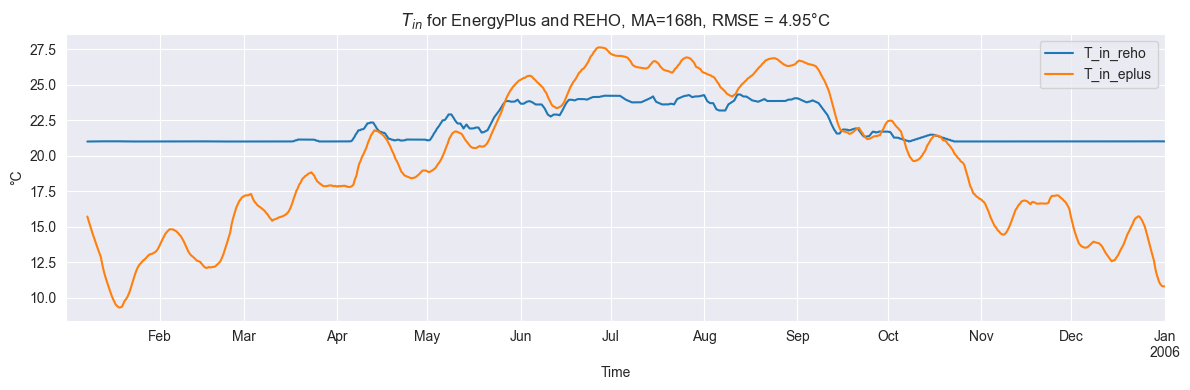

In [148]:
T = 168
base_rmse = rmse(df_base_profiles['T_in_reho'], df_base_profiles['T_in_eplus'])

df_base_profiles.rolling(window=T).mean().plot(kind='line',figsize=(12,4))
plt.xlabel('Time')
plt.ylabel('°C')
plt.title(f'$T_{{in}}$ for EnergyPlus and REHO, MA={T}h, RMSE = {base_rmse:.2f}°C')
plt.tight_layout()

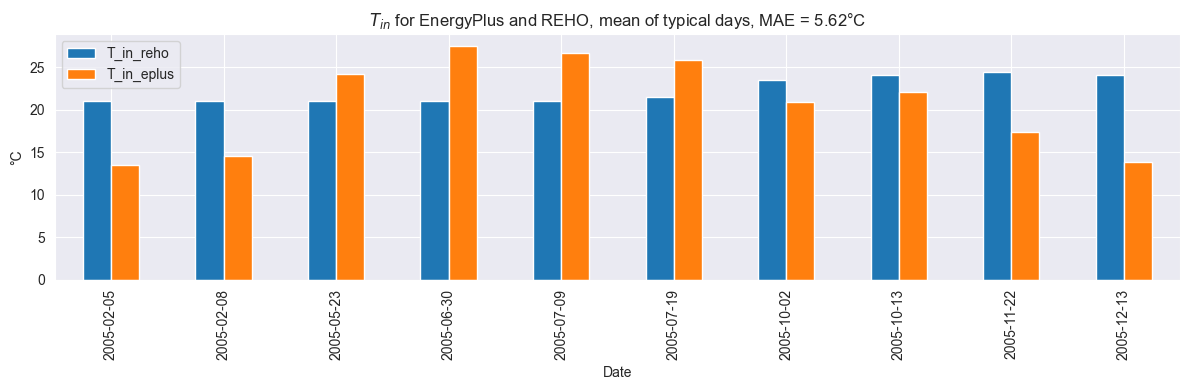

In [149]:
base_mae = mae(df_base_typical['T_in_reho'], df_base_typical['T_in_eplus'])

df_base_typical.groupby(df_base_typical.index.date).mean().plot(kind='bar',figsize=(12,4))
plt.xlabel('Date')
plt.ylabel('°C')
plt.title(f'$T_{{in}}$ for EnergyPlus and REHO, mean of typical days, MAE = {base_mae:.2f}°C')
plt.tight_layout()

## Modify the schedules of the EnergyPlus model

In [155]:
# copy idf
idf_copy = idf.copyidf()

# .copyidf() only copy the idf file part: it is necessary to reassign a weather file
idf_copy.epw = weather_file_path 

new_setpoint = 21
SIA_heating_schedule = '10003_-50_12_21'
SIA_cooling_schedule = '10003_100_28_26'
SIA_heating_schedule_off = '11_-50_12_21'
SIA_cooling_schedule_off = '11_100_28_26'

modify_setpoint(idf_copy, new_setpoint, SIA_heating_schedule, modified_hours=list(range(1, 25)), verbose='q')
modify_setpoint(idf_copy, new_setpoint, SIA_cooling_schedule, modified_hours=list(range(1, 25)), verbose='q')

for entity in idf.idfobjects:
    for field in idf.idfobjects[entity]:
        if 'Name' in field.objls:  # check field with names only
            if SIA_heating_schedule_off in field.Name:  # modify fields where modified SIA file appears
                field.Value_Until_Time_1 = new_setpoint
                   
for entity in idf.idfobjects:
    for field in idf.idfobjects[entity]:
        if 'Name' in field.objls:  # check field with names only
            if SIA_cooling_schedule_off in field.Name:  # modify fields where modified SIA file appears
                field.Value_Until_Time_1 = new_setpoint

In [156]:
reho_relaxed_model, eplus_relaxed_results, df_relaxed_profiles, df_relaxed_typical = explore_profiles(idf_copy, idf_results_path)

Key egid not in the dictionary
Key class not in the dictionary
Key period not in the dictionary
Key capita_cap not in the dictionary
Key height_m not in the dictionary
Key count_floor not in the dictionary
Key source_heating not in the dictionary
Key source_hotwater not in the dictionary
Key x not in the dictionary
Key y not in the dictionary
Key z not in the dictionary
Key geometry not in the dictionary
Key transformer not in the dictionary
Key energy_heating_signature_kWh_y not in the dictionary
Key energy_cooling_signature_kWh_y not in the dictionary
Key energy_hotwater_signature_kWh_y not in the dictionary
Key energy_el_kWh_y not in the dictionary
Key roof_annual_irr_kWh_y not in the dictionary
Key facade_annual_irr_kWh_y not in the dictionary
No geometry in the dataframe
Gurobi 11.0.0: optimal solution; objective 2013.317902
3258 simplex iterations
1 branch-and-cut nodes
plus 13876 simplex iterations for intbasis
              Costs_op  Costs_inv  ANN_factor  Costs_grid_connection

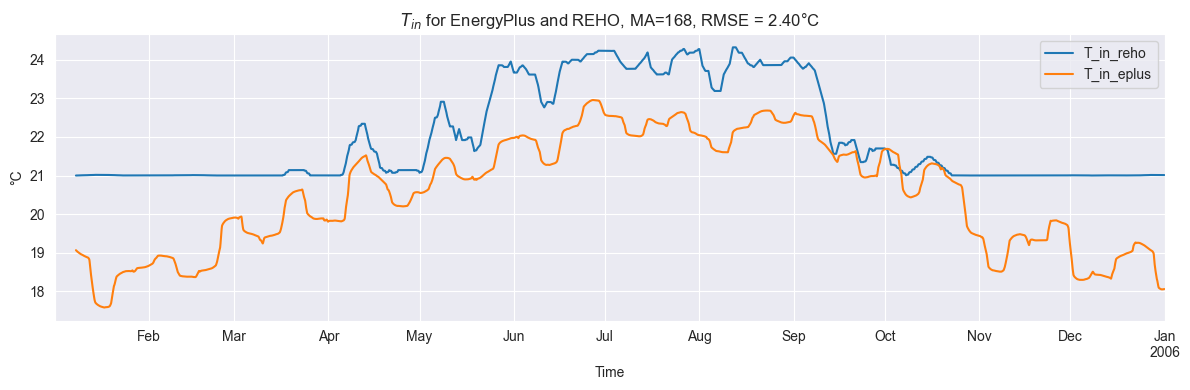

In [157]:
T = 168
relaxed_rmse = rmse(df_relaxed_profiles['T_in_reho'], df_relaxed_profiles['T_in_eplus'])

df_relaxed_profiles.rolling(window=T).mean().plot(kind='line',figsize=(12,4))
plt.xlabel('Time')
plt.ylabel('°C')
plt.title(f'$T_{{in}}$ for EnergyPlus and REHO, MA={T}, RMSE = {relaxed_rmse:.2f}°C')
plt.tight_layout()

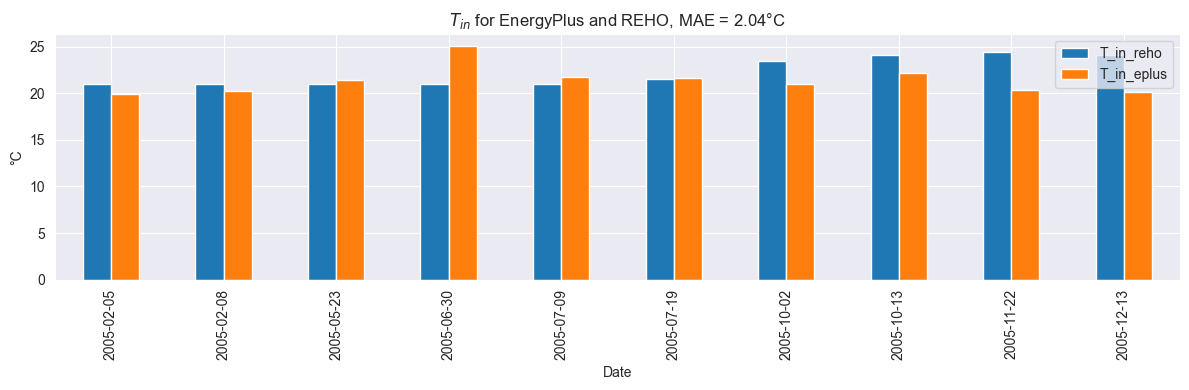

In [158]:
relaxed_mae = mae(df_relaxed_typical['T_in_reho'], df_relaxed_typical['T_in_eplus'])

df_relaxed_typical.groupby(df_relaxed_typical.index.date).mean().plot(kind='bar',figsize=(12,4))
plt.xlabel('Date')
plt.ylabel('°C')
plt.title(f'$T_{{in}}$ for EnergyPlus and REHO, MAE = {relaxed_mae:.2f}°C')
plt.tight_layout()

In [159]:
reho_comfort_model, eplus_comfort_results, df_comfort_profiles, df_comfort_typical = explore_profiles(idf, idf_results_path, T_comfort_min=20, T_comfort_max=22)

Key egid not in the dictionary
Key class not in the dictionary
Key period not in the dictionary
Key capita_cap not in the dictionary
Key height_m not in the dictionary
Key count_floor not in the dictionary
Key source_heating not in the dictionary
Key source_hotwater not in the dictionary
Key x not in the dictionary
Key y not in the dictionary
Key z not in the dictionary
Key geometry not in the dictionary
Key transformer not in the dictionary
Key energy_heating_signature_kWh_y not in the dictionary
Key energy_cooling_signature_kWh_y not in the dictionary
Key energy_hotwater_signature_kWh_y not in the dictionary
Key energy_el_kWh_y not in the dictionary
Key roof_annual_irr_kWh_y not in the dictionary
Key facade_annual_irr_kWh_y not in the dictionary
No geometry in the dataframe
Gurobi 11.0.0: optimal solution; objective 1993.404356
3594 simplex iterations
1 branch-and-cut nodes
plus 11496 simplex iterations for intbasis
              Costs_op   Costs_inv  ANN_factor  Costs_grid_connectio

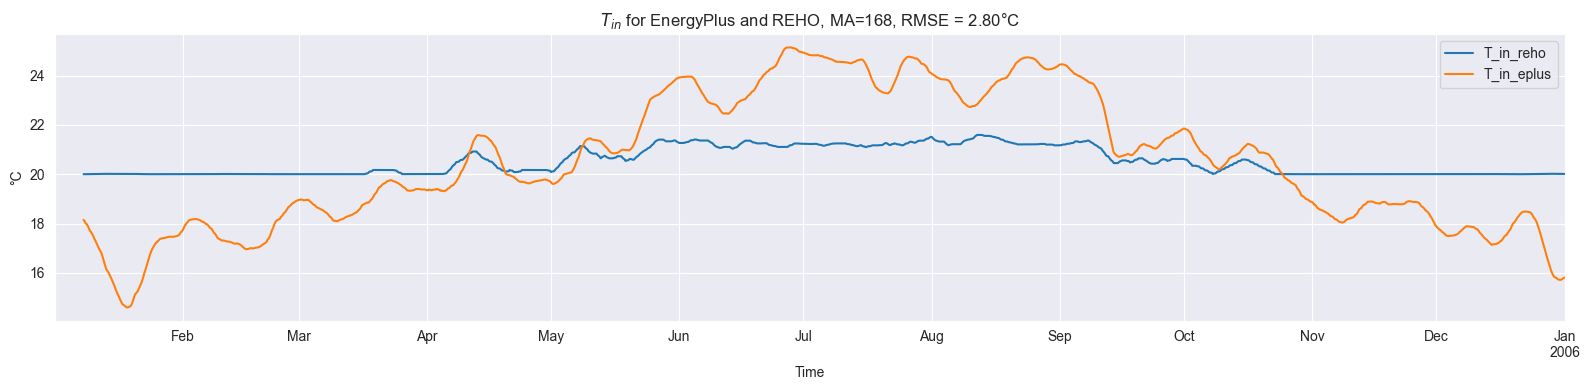

In [160]:
T = 168
comfort_rmse = rmse(df_comfort_profiles['T_in_reho'], df_comfort_profiles['T_in_eplus'])

df_comfort_profiles.rolling(window=T).mean().plot(kind='line',figsize=(16,4))
plt.xlabel('Time')
plt.ylabel('°C')
plt.title(f'$T_{{in}}$ for EnergyPlus and REHO, MA={T}, RMSE = {comfort_rmse:.2f}°C')
plt.tight_layout()

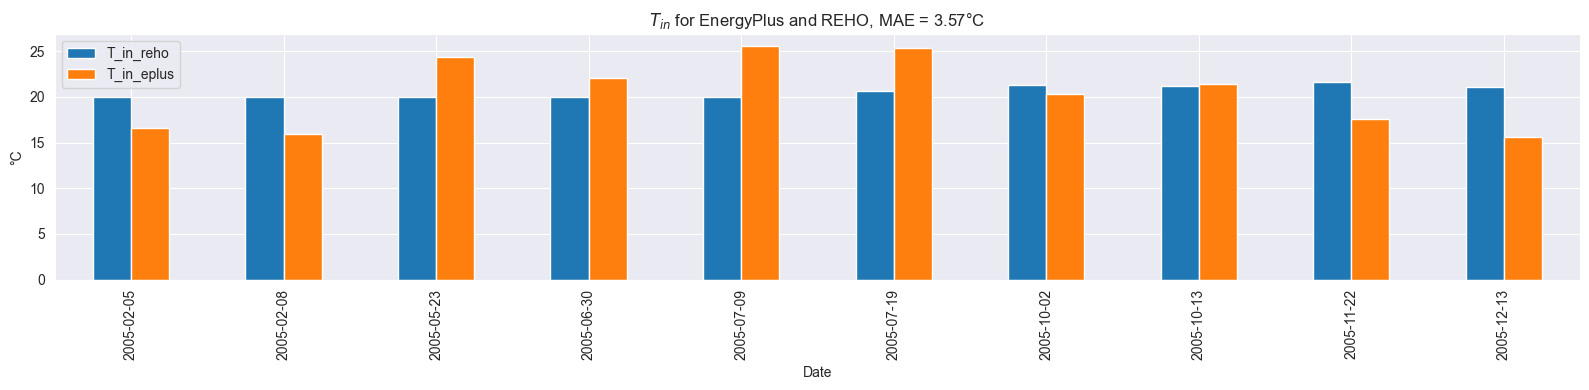

In [161]:
comfort_mae = mae(df_comfort_typical['T_in_reho'], df_comfort_typical['T_in_eplus'])

df_comfort_typical.groupby(df_comfort_typical.index.date).mean().plot(kind='bar',figsize=(16,4))
plt.xlabel('Date')
plt.ylabel('°C')
plt.title(f'$T_{{in}}$ for EnergyPlus and REHO, MAE = {comfort_mae:.2f}°C')
plt.tight_layout()